# Machine Learning for Optimization: Toy Example

Based in my experience, whenever someone asks for a prediction (or forecasting) model, they actually do not need a prediction model per se. They typically want to answer causal questions or do some kind of optimization. I have covered some case studies on causal questions in previous posts (for example, [Introduction to Causal Inference with PPLs](https://juanitorduz.github.io/intro_causal_inference_ppl_pymc/) andn ["Using Data Science for Bad Decision-Making: A Case Study"](https://juanitorduz.github.io/causal_inference_example/)). In this blog post, I want to focus on optimization. I found a little nice use case when workin on adtech, where one is interested in optimizin bids to maximize the revenue (or any other target, like ROAS or lifetime value). How to set the bids? This is a huge active research area so this is by no means an exhaustive treatment. I want to focus on a small component on a recent paper: ["Lightweight Auto-bidding based on Traffic Prediction in Live Advertising"](https://arxiv.org/pdf/2508.06069) where the authors propose a method to se the bids by optimizing on the output of a fitted forecast model. I won't go into the paper scope, but rather focus on a self contained problem: *Algorithm 1 Algorithm BiCB*. The basic idea is as follows: In order to set bids on time intervals we can fit a forecasting model to predict the cummulative cost over the day based on time features and the current bid value $\text{bid}_t$. To set the next bid $\text{bid}_{t + 1}$ we can compare the forecast against the desired target (say, the expected cumulative daily budget at $t + 1$). We can adjust the under/over pacing by minimizing this difference. In other words, we want to steer achieving the target using the bids values through a *time machine* (i.e. a forecasting model) to generate counterfactuals. The paper works out this in certain level of detail, but the comcrete implemention is a bit open. So here we do it bu plain *brute force* (why not?). The whole idea is not to solve this concrete algorithm but to experiment on how to use machine learning methods for optimization purposes. 

We do not work this specific case but work on a generic simulated example as a first iteration to simply get intuition on the techniques.


## Prepare Notebook


In [1]:
from dataclasses import dataclass

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "seed"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Generate Synthetic Data

We start by generating some synthetic data with two features and a target variable (the data generating process is semi-arbitrary).

In [3]:
def make_regression_data(
    rng: np.random.Generator, n_samples: int
) -> tuple[np.ndarray, np.ndarray]:
    x1 = rng.uniform(0, 1, size=n_samples)
    x2 = rng.uniform(0, 1, size=n_samples)
    y = (
        (x1 + x2 - 0.5) ** 2
        - x1**3
        - 0.5
        + np.sin(2 * np.pi * x1 * x2**2)
        + rng.normal(0, 0.1, size=n_samples)
    )
    return np.c_[x1, x2], y


x, y = make_regression_data(rng=rng, n_samples=700)

Let's plot the data.

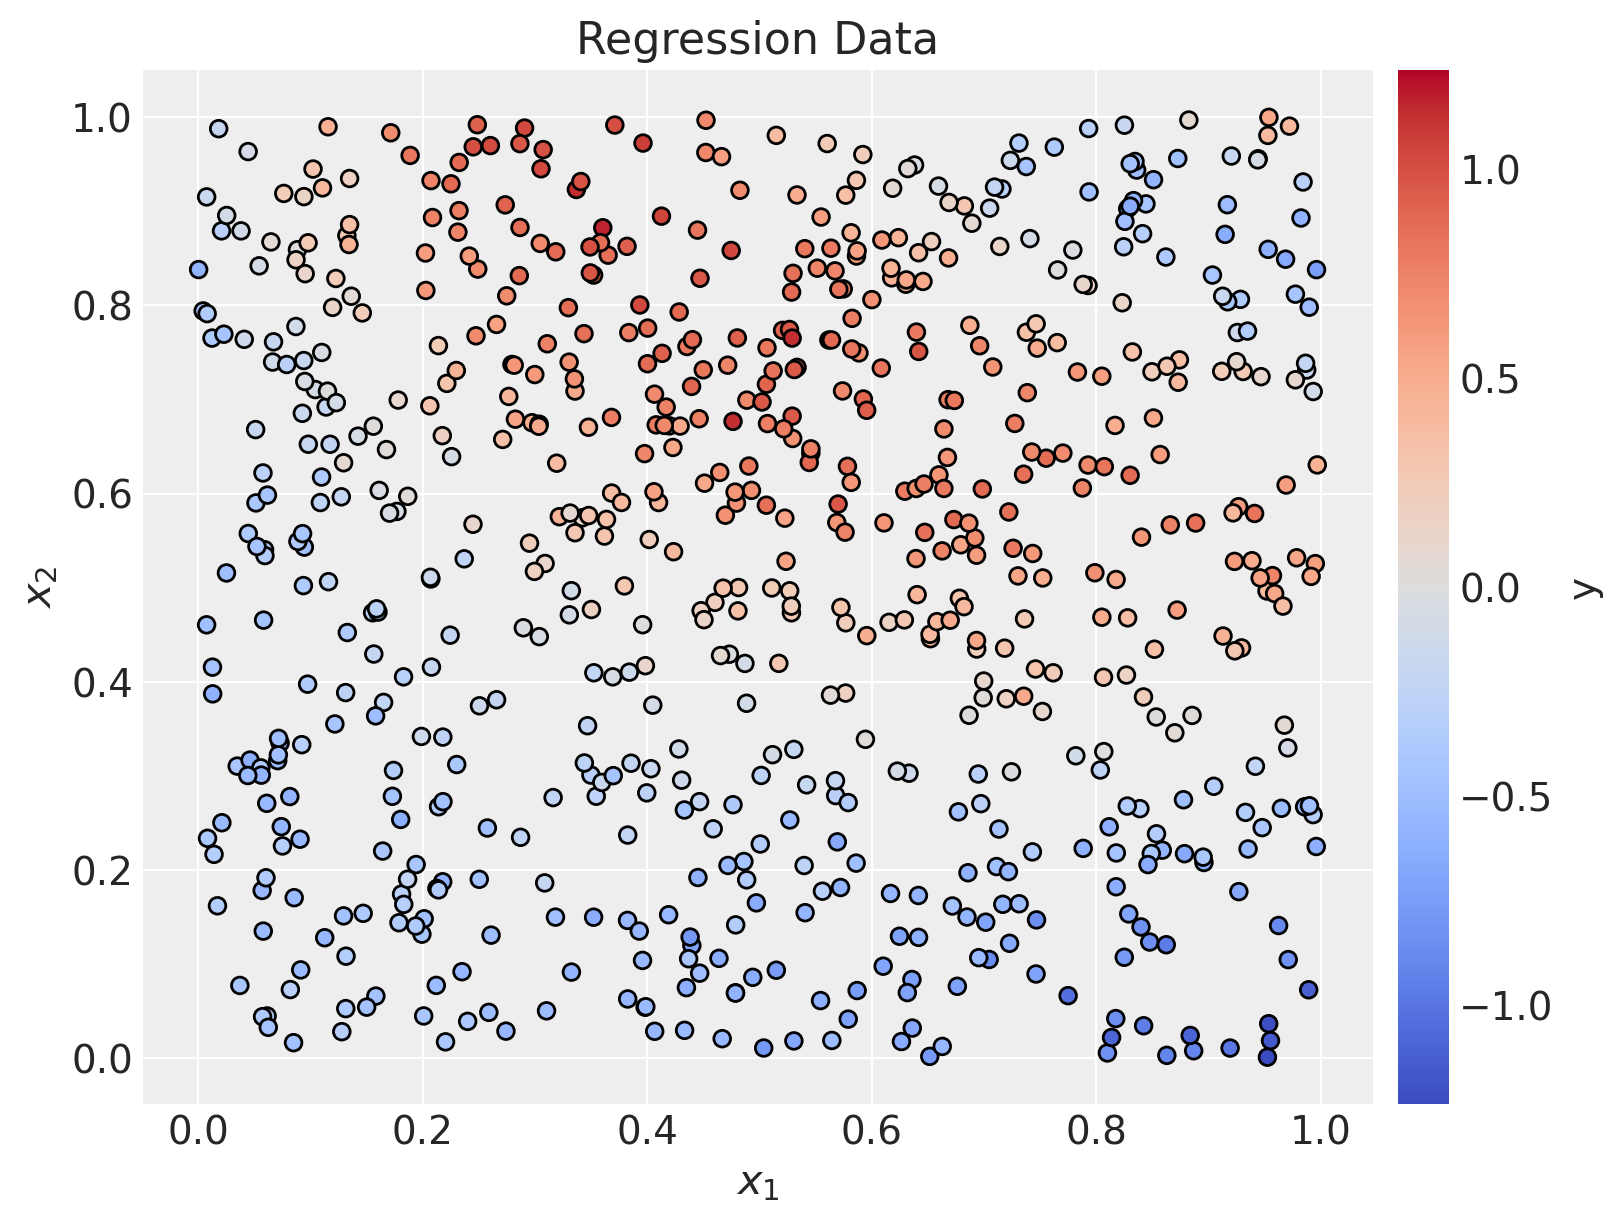

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))

norm = mcolors.Normalize(vmin=-np.max(np.abs(y)), vmax=np.max(np.abs(y)))
sc = ax.scatter(x[:, 0], x[:, 1], c=y, cmap="coolwarm", norm=norm, edgecolors="black")
cbar = plt.colorbar(sc, ax=ax, pad=0.02)
cbar.set_label("y", fontsize=14)
ax.set(xlabel=r"$x_1$", ylabel=r"$x_2$", title="Regression Data");

## Problem Formulation

Here is the problem we are trying to solve:

Given a fixed value of $x_2$ (in the bidding example, these could be time features like hour of the day), we want to find the value of $x_1$ that minimizes the difference between the predicted value of a machine learning model (the *time machine*) and a target value (say, cumulative daily budget).

Hence, we should: 

1. Fit a machine learning model to learn $y$ as a function of $x_1$ and $x_2$.
2. For a given value of $x_2$, find the value of $x_1$ that minimizes the difference between the predicted value of the model and a target value.

Let's do it!


## Fit ML Model

For this regression problem, we will use a great default model: the [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html). Here we skip the hyperparameters tuning and cross-validation for simplicity.

In [5]:
model = HistGradientBoostingRegressor(random_state=seed)

model.fit(x, y)

HistGradientBoostingRegressor(random_state=417)

## Generate Predictions

We can now generate predictions for the whole dataset.

In [6]:
y_pred = model.predict(x)

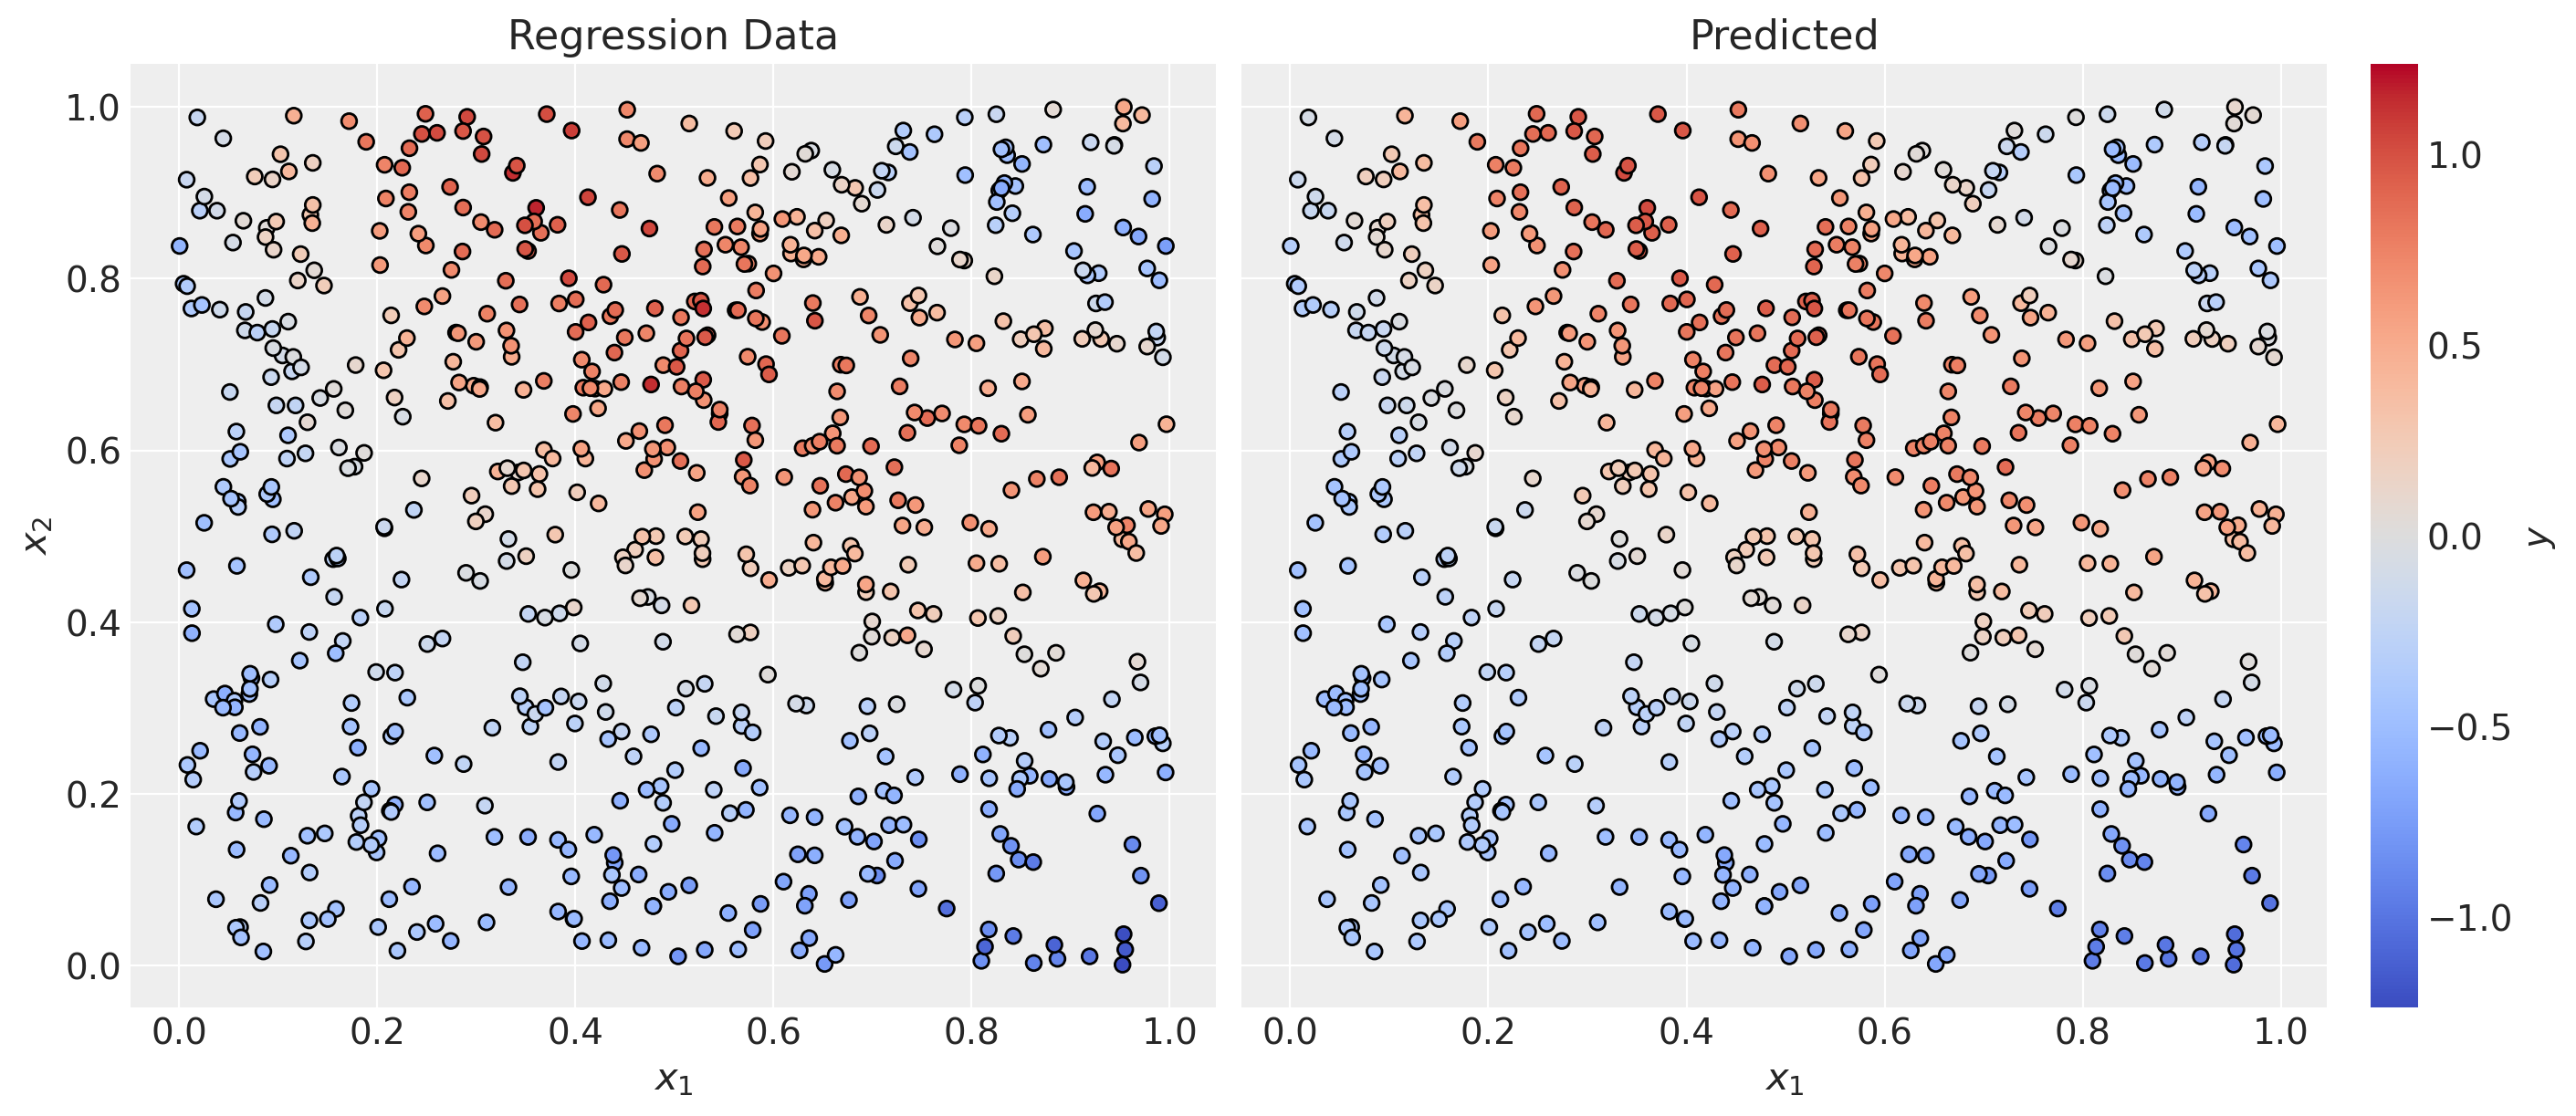

In [7]:
fig, ax = plt.subplots(
    nrows=1, ncols=2, sharex=True, sharey=True, figsize=(14, 6), layout="constrained"
)

sc_0 = ax[0].scatter(
    x[:, 0], x[:, 1], c=y, cmap="coolwarm", norm=norm, edgecolors="black"
)

norm = mcolors.Normalize(vmin=-np.max(np.abs(y)), vmax=np.max(np.abs(y)))
cbar = plt.colorbar(sc_0, ax=ax, pad=0.02)
cbar.set_label(r"$y$", fontsize=14)


ax[0].set(xlabel=r"$x_1$", ylabel=r"$x_2$", title="Regression Data")

sc_1 = ax[1].scatter(
    x[:, 0], x[:, 1], c=y_pred, cmap="coolwarm", norm=norm, edgecolors="black"
)
ax[1].set(xlabel=r"$x_1$", ylabel=None, title="Predicted");

In [8]:
mae = mean_absolute_error(y, y_pred)
print(f"MAE: {mae:.2f}")

MAE: 0.06


Overall, the model looks good.

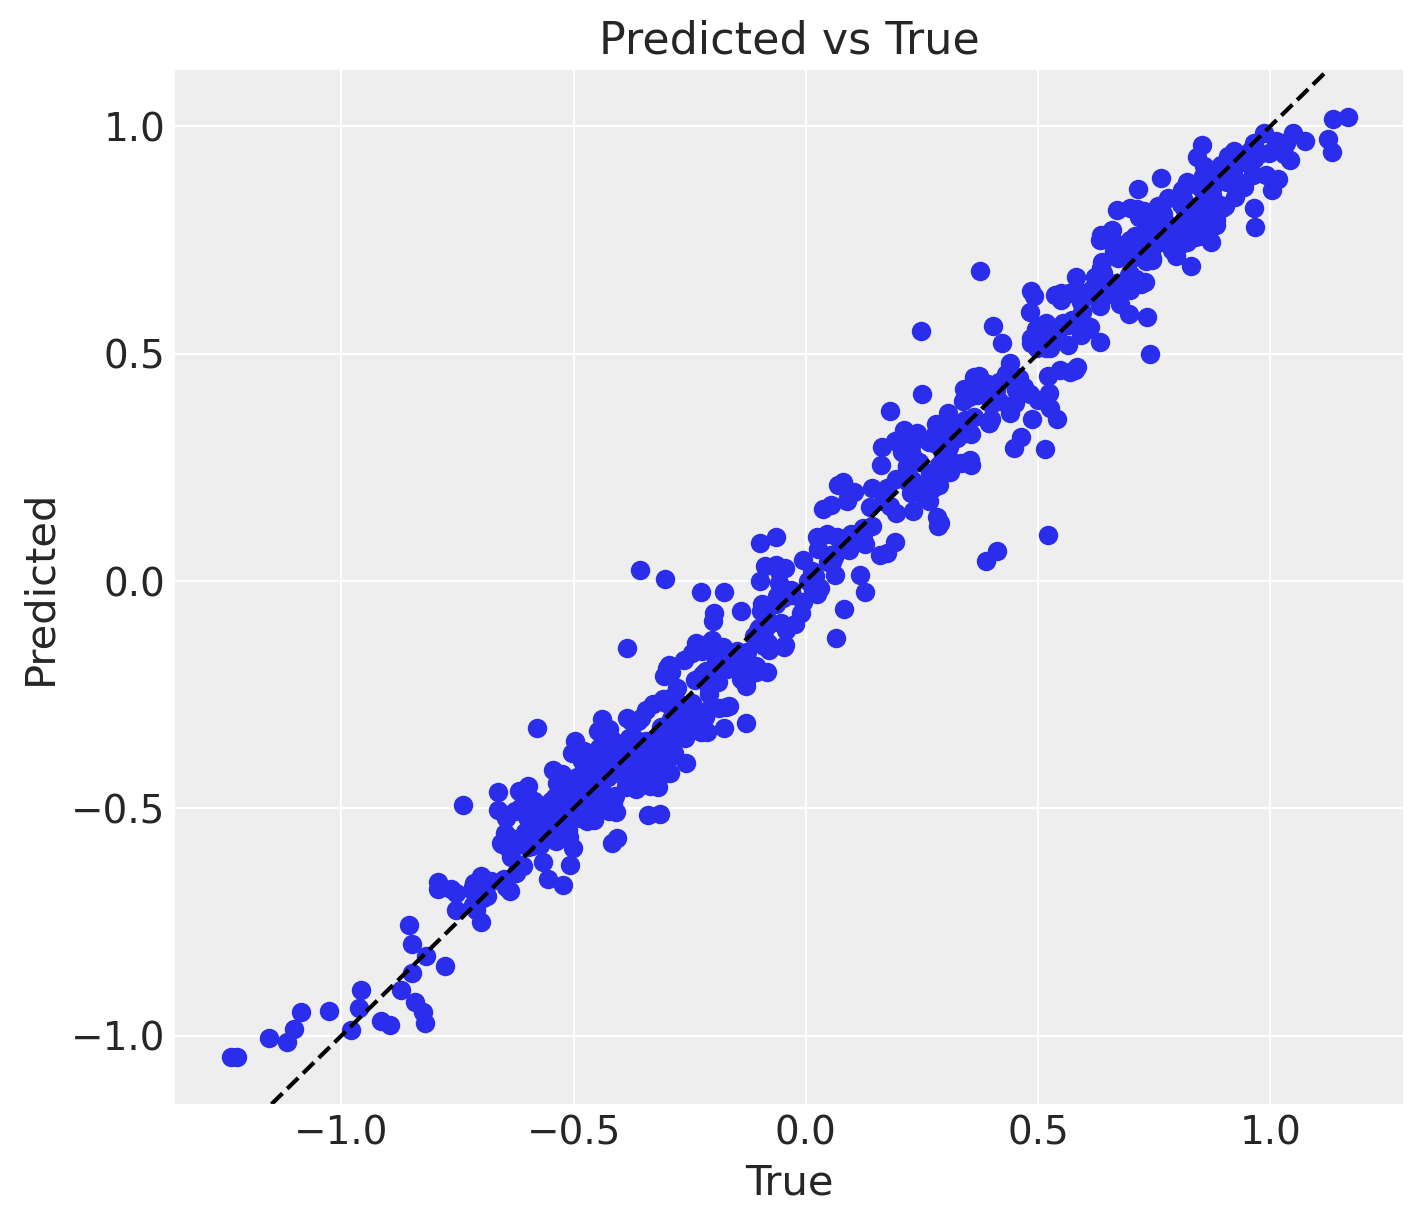

In [9]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(y, y_pred)
ax.axline(xy1=(0, 0), slope=1, color="black", linestyle="--")
ax.set(xlabel="True", ylabel="Predicted", title="Predicted vs True");

## Optimization Step

Now that we have a model, we can use it for optimization.

Firs, let us define the input parameters.

In [10]:
@dataclass
class OptimizationParameters:
    x2_fixed: float  # Fixed value of x2
    y_target: float  # Target value
    bounds: tuple[float, float]  # Bounds of x1

    @property
    def get_initial_guess(self) -> float:
        return (self.bounds[0] + self.bounds[1]) / 2


optimization_parameters = OptimizationParameters(
    x2_fixed=0.65, y_target=0.5, bounds=(0.2, 0.6)
)

Now, we use the fitted model to generate predictions by freezing the value of $x_2$.

In [11]:
def model_predict_at_x2_fixed(x1: float, x2_fixed: float) -> float:
    return model.predict(np.c_[x1, x2_fixed]).item()

Let's visualize the predictions on a grid of $x_1$ values.

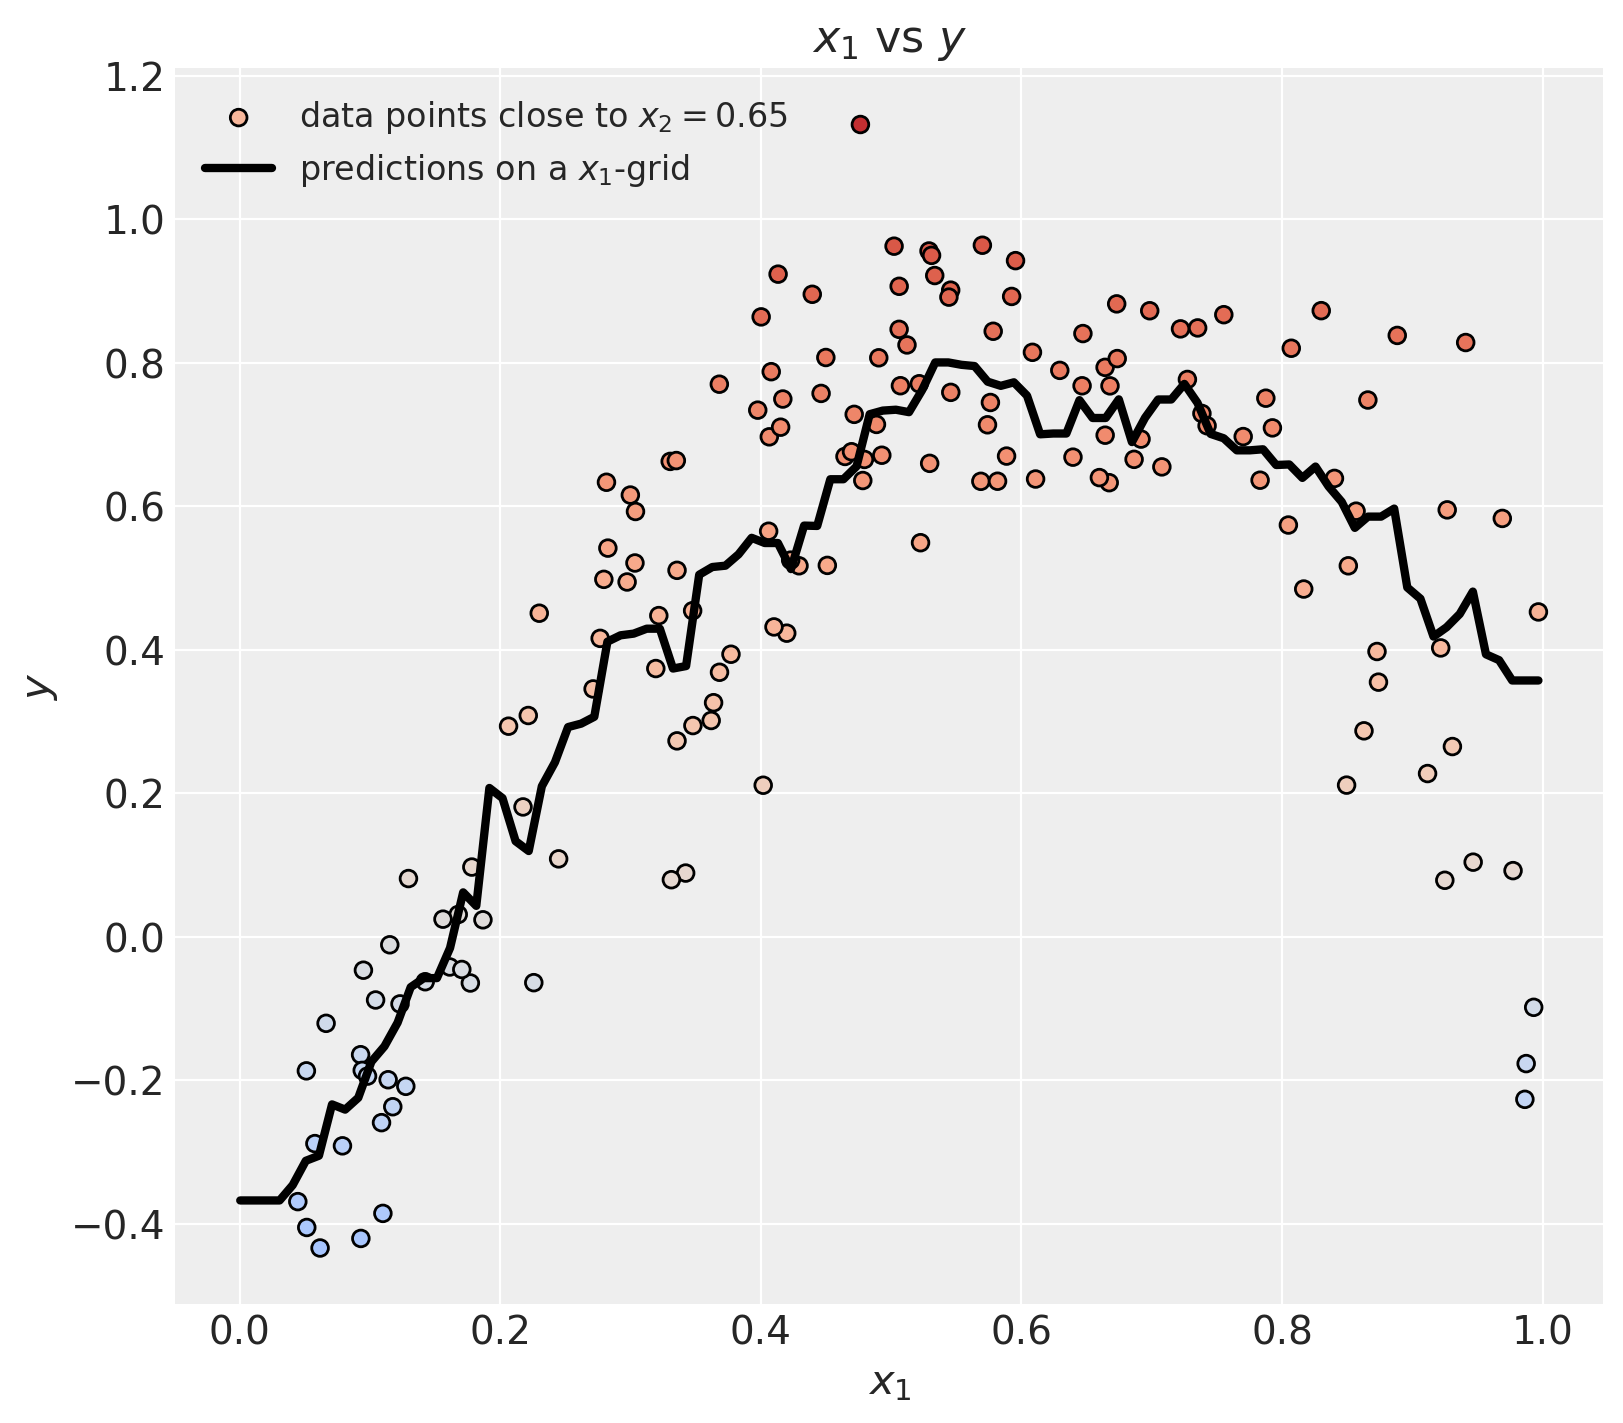

In [12]:
# Generate a grid of x1 values
x1_grid = np.linspace(x[:, 0].min(), x[:, 0].max(), 100)
# Vectorize the model prediction function
y_pred_grid = np.vectorize(model_predict_at_x2_fixed)(
    x1_grid, optimization_parameters.x2_fixed
)

# Get the mask of the points that are close to the fixed x2 value
# (just for visualization purposes)
mask = np.abs(x[:, 1] - optimization_parameters.x2_fixed) < 0.1

fig, ax = plt.subplots(figsize=(8, 7))
ax.scatter(
    x[:, 0][mask],
    y[mask],
    c=y[mask],
    cmap="coolwarm",
    norm=norm,
    edgecolors="black",
    label=rf"data points close to $x_2 = {optimization_parameters.x2_fixed}$",
)
ax.plot(
    x1_grid,
    y_pred_grid,
    c="black",
    linewidth=3,
    label=r"predictions on a $x_1$-grid",
)
ax.legend(loc="upper left", fontsize=12)
ax.set(xlabel=r"$x_1$", ylabel=r"$y$", title=r"$x_1$ vs $y$");

We can zoom in to the region of interest.

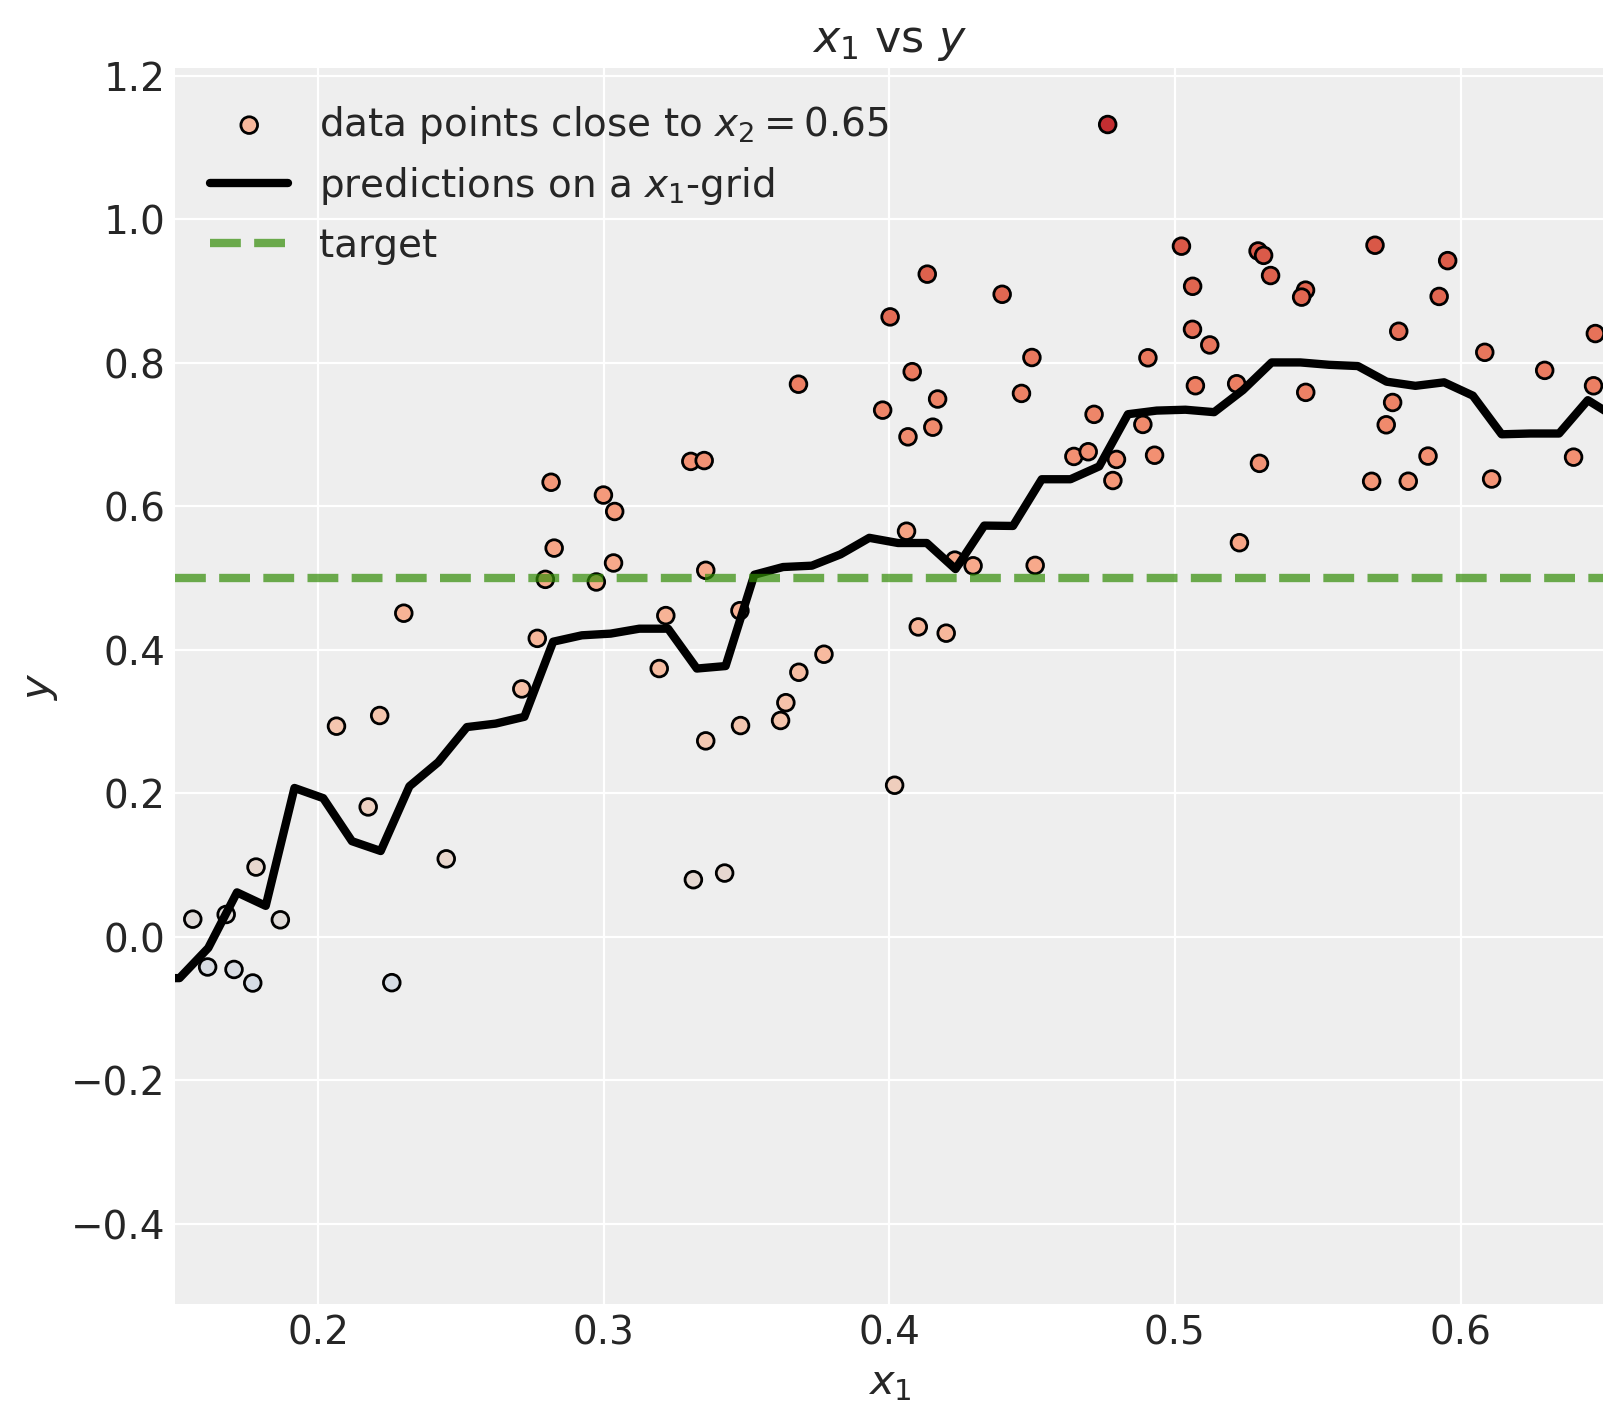

In [13]:
fig, ax = plt.subplots(figsize=(8, 7))
ax.scatter(
    x[:, 0][mask],
    y[mask],
    c=y[mask],
    cmap="coolwarm",
    norm=norm,
    edgecolors="black",
    label=rf"data points close to $x_2 = {optimization_parameters.x2_fixed}$",
)
ax.plot(
    x1_grid,
    y_pred_grid,
    c="black",
    linewidth=3,
    label=r"predictions on a $x_1$-grid",
)
ax.axhline(
    optimization_parameters.y_target,
    color="C2",
    linestyle="--",
    linewidth=3,
    alpha=0.7,
    label=r"target",
)
ax.legend(loc="upper left")
ax.set(xlabel=r"$x_1$", ylabel=r"$y$", title=r"$x_1$ vs $y$", xlim=(0.15, 0.65));

Now we can use [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to find the value of $x_1$ that minimizes the difference between the predicted value of the model and the target value.

Observe that tree-based models have piecewise constant predictions, so gradient-based optimizers (default BFGS) won't work (because the gradient is zero almost everywhere). We should use a gradient-free method like Nelder-Mead or Powell.


In [14]:
# Define the function to minimize
def function_to_minimize(x, x2_fixed, y_target):
    # We want to minimize the difference between the predicted
    # value and the target value.
    return abs(model_predict_at_x2_fixed(x, x2_fixed) - y_target)


optimization_result = minimize(
    function_to_minimize,
    x0=optimization_parameters.get_initial_guess,
    args=(optimization_parameters.x2_fixed, optimization_parameters.y_target),
    method="Powell",
    bounds=[optimization_parameters.bounds],
)

optimization_result

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.004673598436508053
       x: [ 3.528e-01]
     nit: 2
   direc: [[ 1.000e+00]]
    nfev: 24

Finally, we can visualize the result.

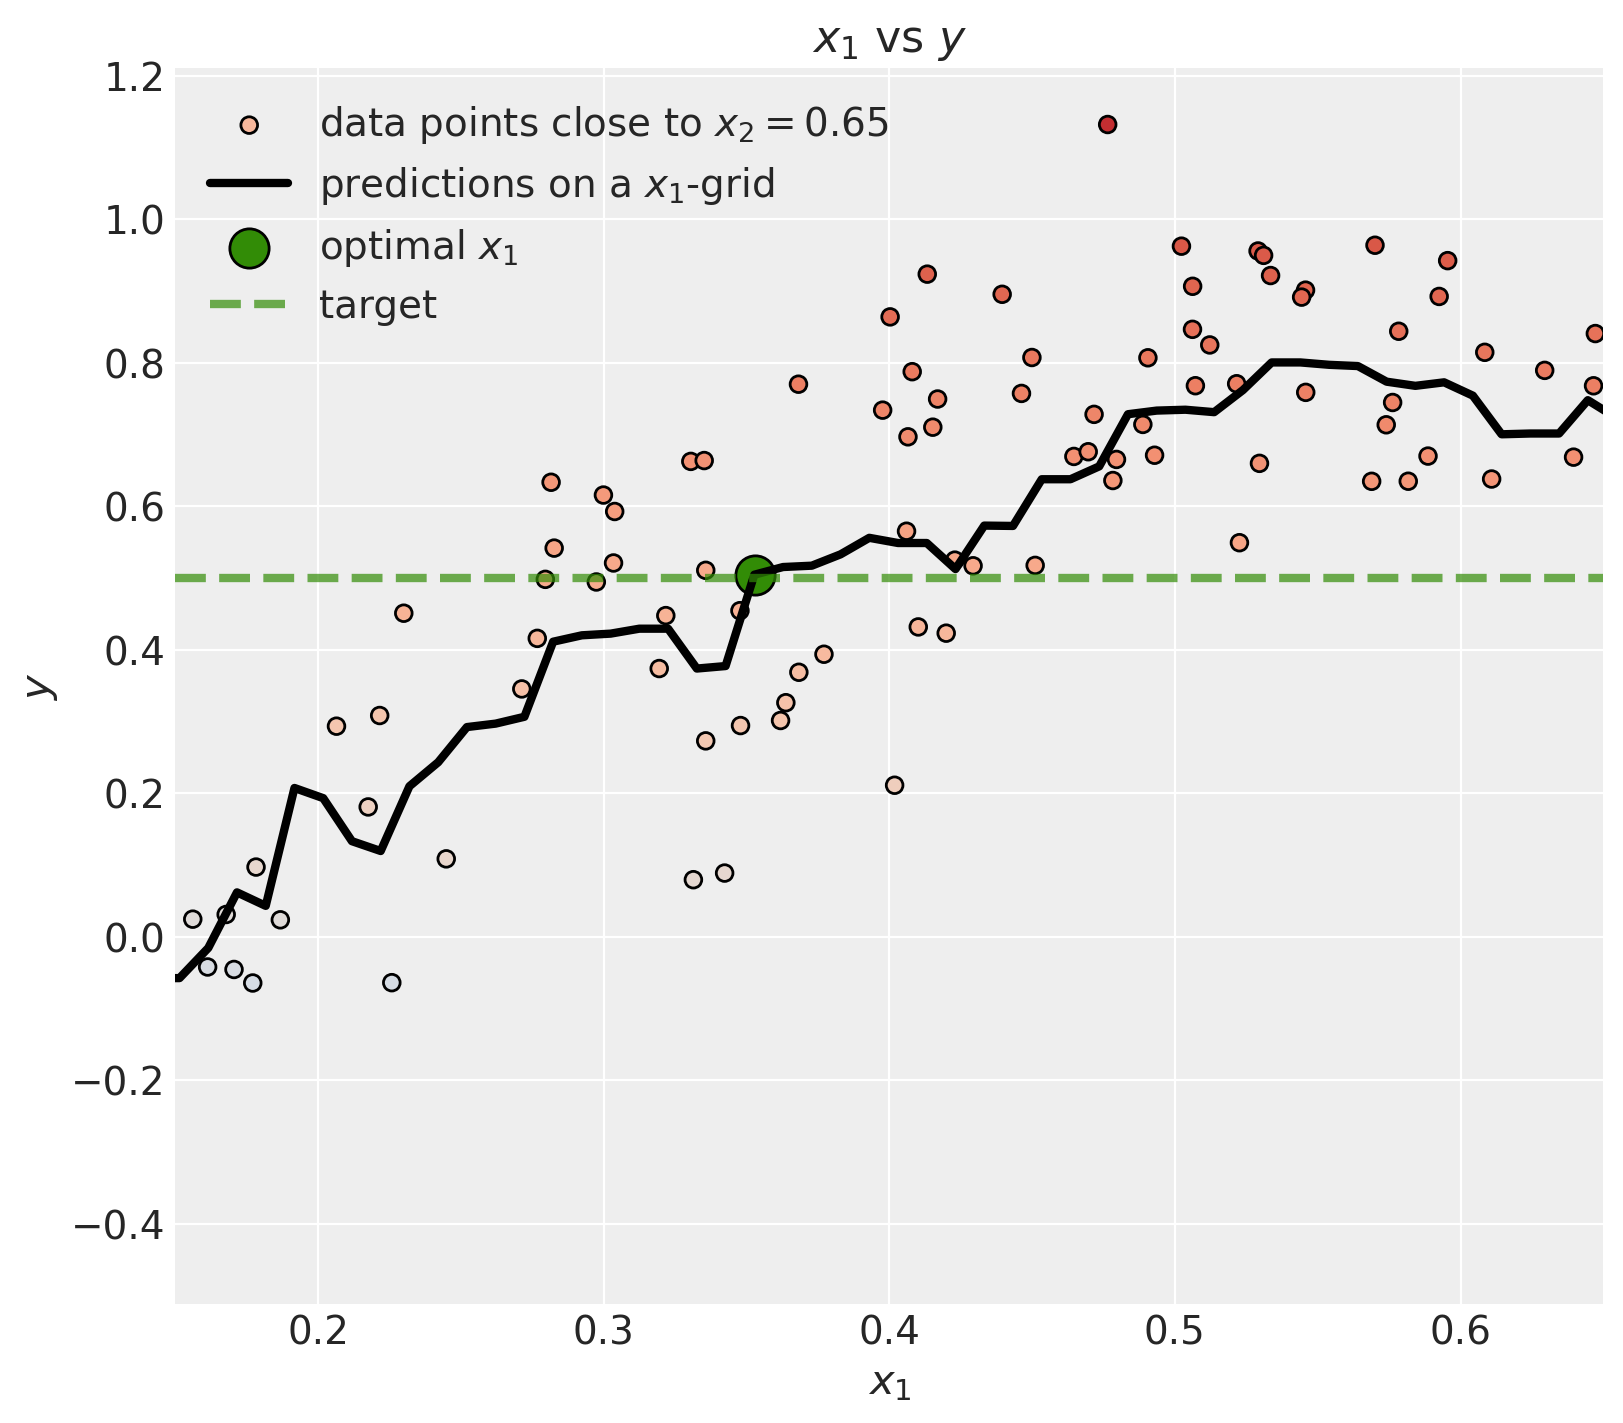

In [15]:
fig, ax = plt.subplots(figsize=(8, 7))
ax.scatter(
    x[:, 0][mask],
    y[mask],
    c=y[mask],
    cmap="coolwarm",
    norm=norm,
    edgecolors="black",
    label=rf"data points close to $x_2 = {optimization_parameters.x2_fixed}$",
)
ax.plot(
    x1_grid,
    y_pred_grid,
    c="black",
    linewidth=3,
    label=r"predictions on a $x_1$-grid",
)
ax.scatter(
    optimization_result.x,
    optimization_result.fun + optimization_parameters.y_target,
    c="C2",
    marker="o",
    edgecolors="black",
    s=200,
    label=r"optimal $x_1$",
)
ax.axhline(
    optimization_parameters.y_target,
    color="C2",
    linestyle="--",
    alpha=0.7,
    linewidth=3,
    label=r"target",
)
ax.legend(loc="upper left")
ax.set(xlabel=r"$x_1$", ylabel=r"$y$", title=r"$x_1$ vs $y$", xlim=(0.15, 0.65));

We can see that the optimal $x_1$ does hit the target. as expected 🚀!

We can explicitly plot the objective function.

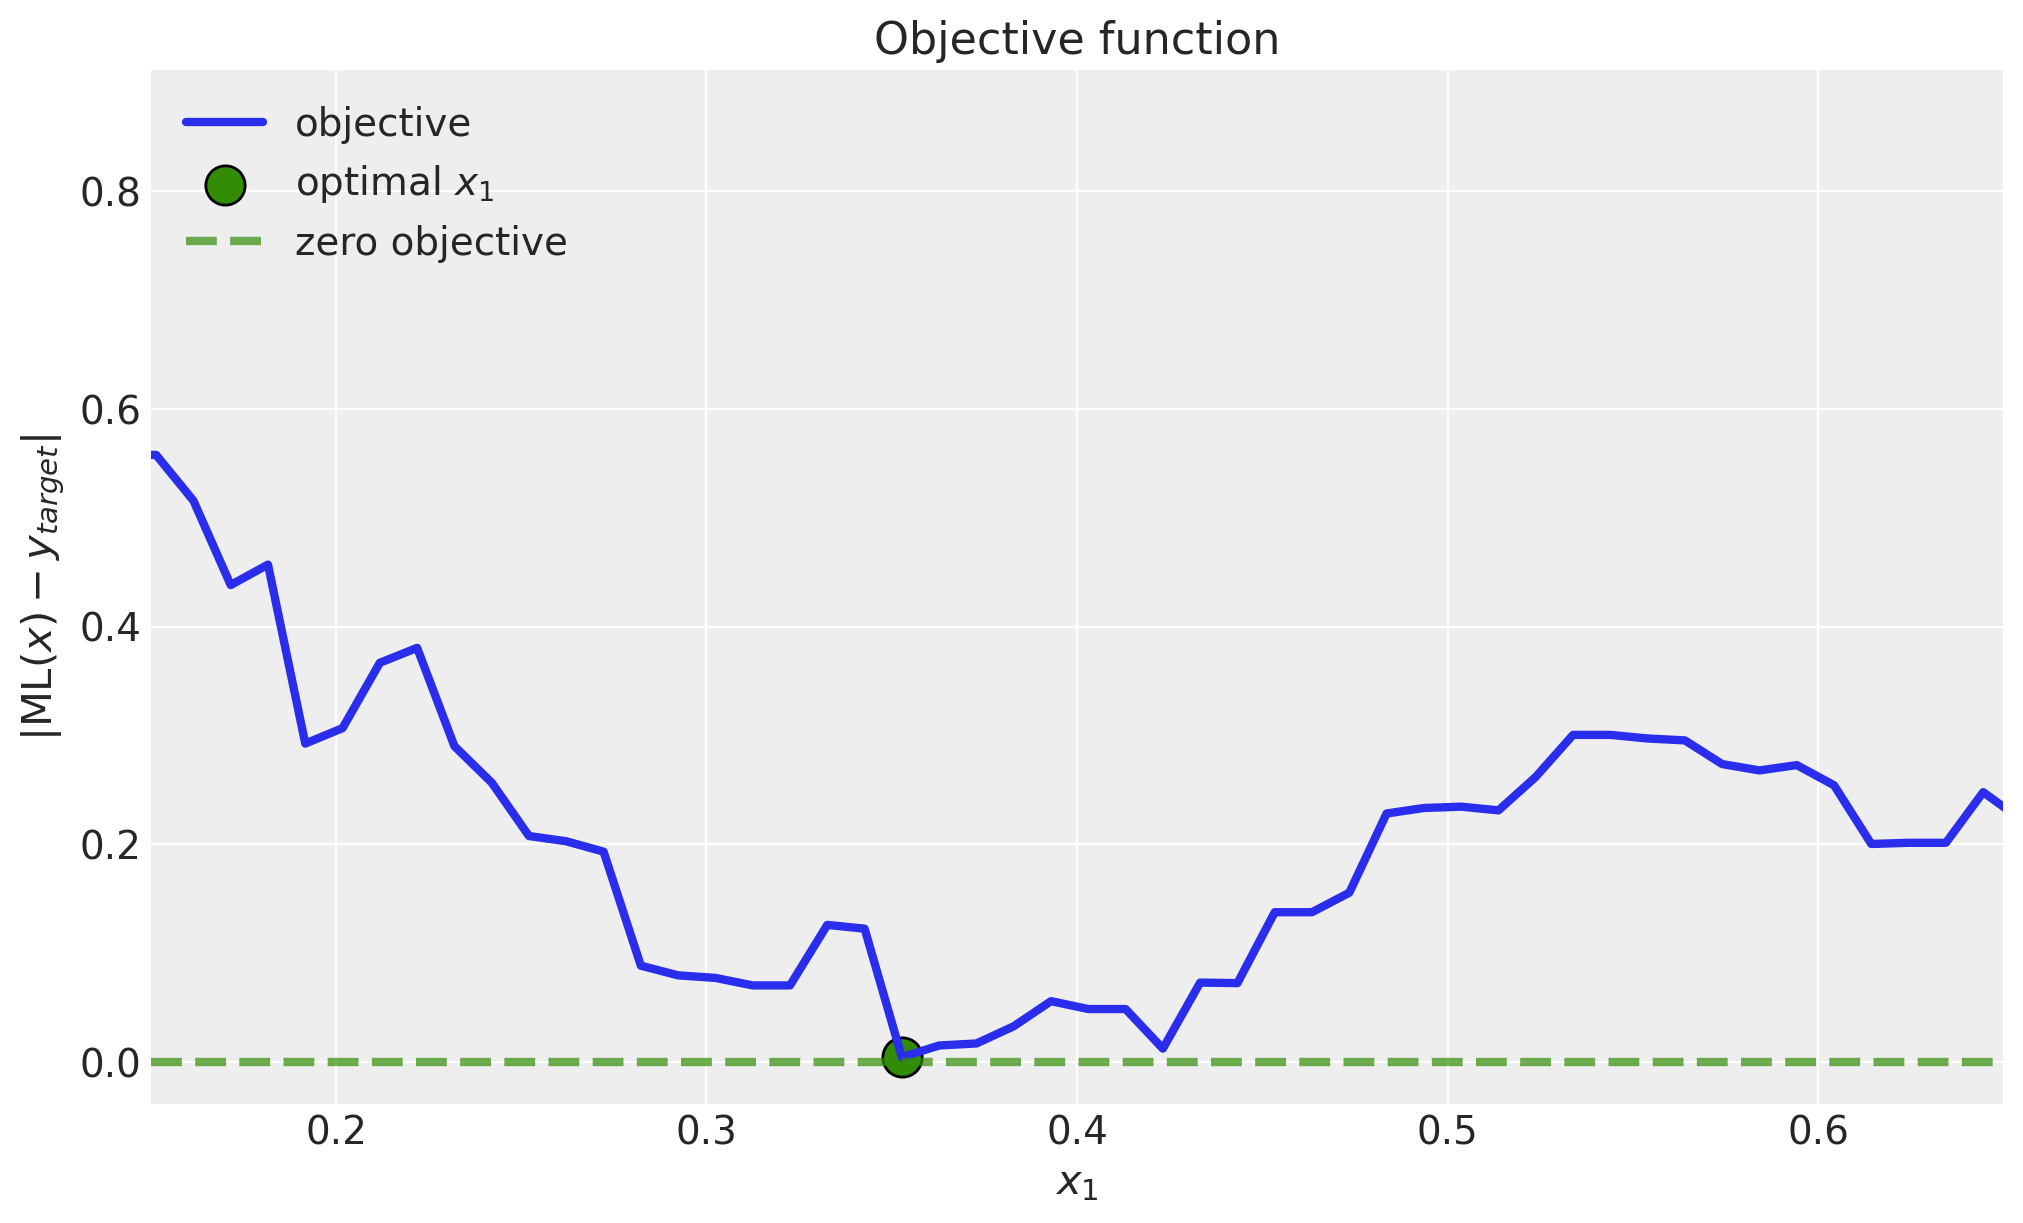

In [16]:
objective_grid = np.vectorize(function_to_minimize)(
    x1_grid, optimization_parameters.x2_fixed, optimization_parameters.y_target
)


fig, ax = plt.subplots()
ax.plot(x1_grid, objective_grid, c="C0", linewidth=3, label="objective")
ax.scatter(
    optimization_result.x,
    optimization_result.fun,
    c="C2",
    marker="o",
    edgecolors="black",
    s=200,
    label=r"optimal $x_1$",
)
ax.axhline(
    0.0,
    color="C2",
    linestyle="--",
    alpha=0.7,
    linewidth=3,
    label="zero objective",
)
ax.legend(loc="upper left")
ax.set(
    xlabel=r"$x_1$",
    ylabel=r"$ |\text{ML}(x) - y_{target}|$",
    title="Objective function",
    xlim=(0.15, 0.65),
);